### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Input, Dense

from keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Input, Reshape, Flatten, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, confusion_matrix
import keras
from keras import layers

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv("Dataset/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df1  = pd.read_csv("Dataset/test.csv")
df1.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Splitting and Reshaping the dataset

In [4]:
x_train = df.drop(['label'], axis=1).values
train_y = df['label'].values
x_test = df1.values

print("X_train shape", x_train.shape)
print("y_test shape", train_y.shape)
print("X_test shape", x_test.shape)

X_train shape (42000, 784)
y_test shape (42000,)
X_test shape (28000, 784)


In [5]:
IMG_SIZE = 32

In [6]:
import cv2

def resize(img_array):
    tmp = np.empty((img_array.shape[0], IMG_SIZE, IMG_SIZE))

    for i in range(len(img_array)):
        img = img_array[i].reshape(28, 28).astype('uint8')
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')/255
        tmp[i] = img
        
    return tmp

x_train = resize(x_train)
x_test = resize(x_test)

In [7]:
X_train_final = np.stack((x_train,)*3, axis=-1)
X_test_final = np.stack((x_test,)*3, axis=-1)
print(X_train_final.shape)
print(X_test_final.shape)

(42000, 32, 32, 3)
(28000, 32, 32, 3)


In [8]:
y_train_final = to_categorical(train_y, num_classes=10)
print(y_train_final.shape)

(42000, 10)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=2021)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33600, 32, 32, 3)
(8400, 32, 32, 3)
(33600, 10)
(8400, 10)


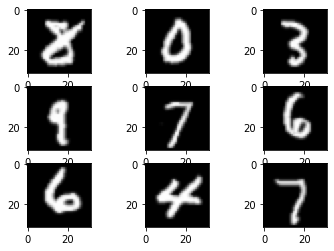

In [10]:
# plot first few images
import matplotlib.pyplot as plt
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

#### Code which helps to plot the Accuracy and Loss Curve

In [11]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    plt.figsize=(10, 10)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    plt.figsize=(10, 10)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Comparitive-Models

### Convolution Neural Network (CNN)

In [15]:
model1 = Sequential()
model1.add(Conv2D(IMG_SIZE, (3, 3), activation='relu', padding='valid'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(10, activation='softmax'))
model1.compile(loss='categorical_crossentropy',
              optimizer="adam", metrics=['accuracy'])

In [16]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='CNN.h5', verbose=1, monitor='val_acc')
cb = [es, mc]

In [17]:
history1 = model1.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(X_test, y_test),
                    callbacks=cb)

Epoch 1/50
263/263 [==============================] - 36s 34ms/step - loss: 0.4028 - accuracy: 0.8775 - val_loss: 0.0839 - val_accuracy: 0.9718

Epoch 00001: saving model to CNN.h5
Epoch 2/50
263/263 [==============================] - 7s 25ms/step - loss: 0.0604 - accuracy: 0.9819 - val_loss: 0.0580 - val_accuracy: 0.9824

Epoch 00002: saving model to CNN.h5
Epoch 3/50
263/263 [==============================] - 6s 24ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.0533 - val_accuracy: 0.9850

Epoch 00003: saving model to CNN.h5
Epoch 4/50
263/263 [==============================] - 6s 25ms/step - loss: 0.0209 - accuracy: 0.9935 - val_loss: 0.0543 - val_accuracy: 0.9854

Epoch 00004: saving model to CNN.h5
Epoch 5/50
263/263 [==============================] - 11s 41ms/step - loss: 0.0148 - accuracy: 0.9951 - val_loss: 0.0591 - val_accuracy: 0.9846

Epoch 00005: saving model to CNN.h5
Epoch 6/50
263/263 [==============================] - 7s 26ms/step - loss: 0.0110 - accuracy: 0.99

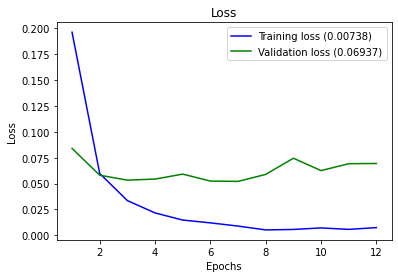

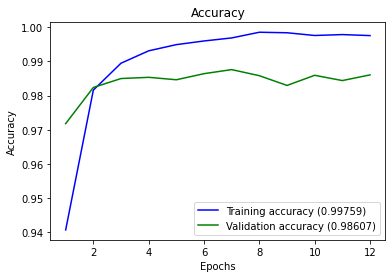

In [18]:
plot_history(history1)

In [19]:
score1 = model1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy CNN%:', (score1[1]*100))

Test accuracy CNN%: 98.60714077949524


In [20]:
pred_1=model1.predict(X_test, batch_size=128)
y_pred_1= pred_1.argmax(axis=-1)

y_true_onehot = y_test
y_true_label = np.argmax(y_true_onehot, axis=1)
y_true = y_true_label
y_pred1 = y_pred_1
print(y_pred1[0:10])

[1 2 7 1 0 4 6 3 0 3]


In [21]:
cm = confusion_matrix(y_true, y_pred1)
print(cm)

[[772   0   0   2   0   0   5   0   1   1]
 [  0 946   0   0   1   0   1   3   1   1]
 [  0   0 877   1   0   0   0   1   0   2]
 [  0   1   4 868   0   3   0   0   5   0]
 [  0   1   0   0 829   0   4   0   0   4]
 [  0   0   1  11   0 728   7   0   3   2]
 [  0   0   0   0   2   2 818   0   2   0]
 [  2   0   5   0   3   1   0 894   5   2]
 [  0   1   1   3   1   3   2   0 743   1]
 [  1   0   1   2   3   3   0   2   3 808]]


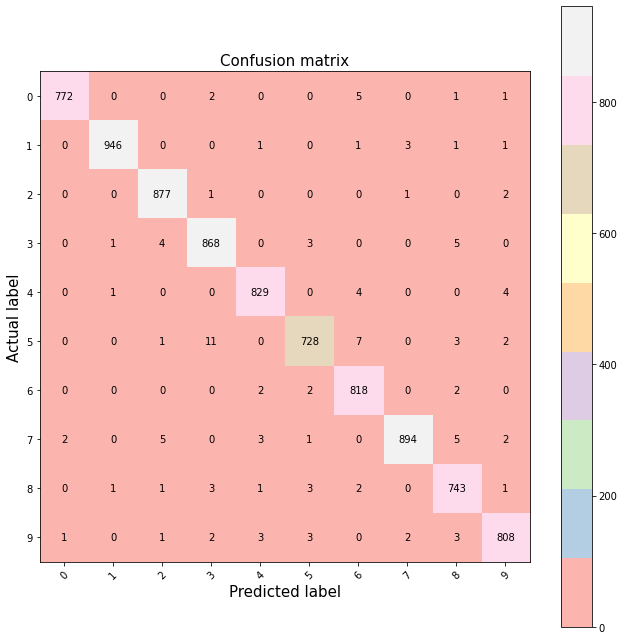

In [22]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
plt.savefig('CNN.png')


### Convolution Neural Network with AutoEncoder

In [23]:
input_signal = Input(shape=(32, 32, 3))

#ENCODER
 
e = Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding='same',  kernel_initializer='he_uniform')(input_signal)
e = MaxPooling2D(pool_size = (2, 2), padding='same')(e)
e = Dropout(0.1)(e)


e = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same',  kernel_initializer='he_uniform')(e)
e = MaxPooling2D(pool_size = (2, 2), padding='same')(e)
e = Dropout(0.1)(e)

e = Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same',  kernel_initializer='he_uniform')(e)
e = MaxPooling2D(pool_size = (2, 2), padding='same')(e)
e = Dropout(0.1)(e)

##DECODER
d = Conv2D(256, (3, 3), activation='relu', padding='same',  kernel_initializer='he_uniform')(e)
d = MaxPooling2D(pool_size = (2, 2), padding='same')(d)
d = Dropout(0.1)(d)

d = Conv2D(256, (3, 3), activation='relu', padding='same',  kernel_initializer='he_uniform')(d)
d = MaxPooling2D(pool_size = (2, 2), padding='same')(d)
d = Dropout(0.1)(d)

d = Conv2D(512, (3, 3), activation='relu', padding='same',  kernel_initializer='he_uniform')(d)
d = MaxPooling2D(pool_size = (2, 2), padding='same')(d)
d = Dropout(0.1)(d)

d = Flatten()(d)
decoded = Dense(10, activation="softmax")(d)


model2 = Model(inputs=input_signal, outputs=decoded)
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 512)       14336     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 512)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       1179904   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 256)         0     

In [24]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='CNN-AutoEncoder.h5', verbose=1, monitor='val_acc')
cb = [es, mc]

In [25]:
history2 = model2.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(X_test, y_test),
                    callbacks=cb)
scores = model2.evaluate(X_test, y_test, verbose=0)

Epoch 1/50
263/263 [==============================] - 61s 207ms/step - loss: 0.9002 - accuracy: 0.7010 - val_loss: 0.0572 - val_accuracy: 0.9819

Epoch 00001: saving model to CNN-AutoEncoder.h5
Epoch 2/50
263/263 [==============================] - 53s 203ms/step - loss: 0.0756 - accuracy: 0.9769 - val_loss: 0.0414 - val_accuracy: 0.9883

Epoch 00002: saving model to CNN-AutoEncoder.h5
Epoch 3/50
263/263 [==============================] - 56s 214ms/step - loss: 0.0513 - accuracy: 0.9845 - val_loss: 0.0478 - val_accuracy: 0.9864

Epoch 00003: saving model to CNN-AutoEncoder.h5
Epoch 4/50
263/263 [==============================] - 58s 219ms/step - loss: 0.0401 - accuracy: 0.9879 - val_loss: 0.0448 - val_accuracy: 0.9860

Epoch 00004: saving model to CNN-AutoEncoder.h5
Epoch 5/50
263/263 [==============================] - 58s 220ms/step - loss: 0.0331 - accuracy: 0.9894 - val_loss: 0.0405 - val_accuracy: 0.9890

Epoch 00005: saving model to CNN-AutoEncoder.h5
Epoch 6/50
263/263 [==========

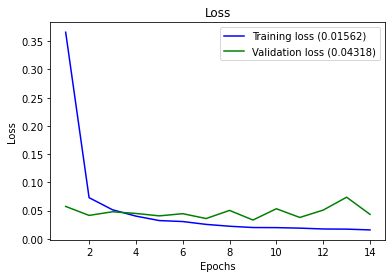

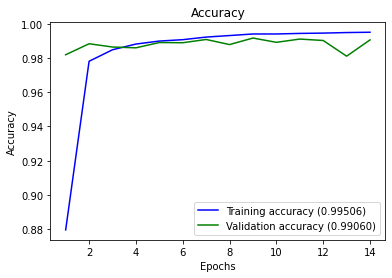

In [26]:
plot_history(history2)

In [27]:
score2 = model2.evaluate(X_test, y_test, verbose=0)
print('Test accuracy CNN AutoEncoder%:', (score2[1]*100))

Test accuracy CNN%: 99.05952215194702


In [28]:
pred_2=model2.predict(X_test, batch_size=128)
y_pred_2= pred_2.argmax(axis=-1)

y_true_onehot = y_test
y_true_label = np.argmax(y_true_onehot, axis=1)
y_true = y_true_label
y_pred2 = y_pred_2
print(y_pred2[0:10])

[1 2 7 1 0 4 6 3 0 3]


In [29]:
cm = confusion_matrix(y_true, y_pred2)
print(cm)

[[773   0   3   0   0   1   2   0   2   0]
 [  0 951   0   0   0   0   0   2   0   0]
 [  0   0 874   2   0   0   0   4   0   1]
 [  0   1   3 870   0   4   0   0   3   0]
 [  0   1   0   0 833   0   0   1   0   3]
 [  0   0   0   1   0 746   1   0   3   1]
 [  0   0   1   0   1   2 815   0   5   0]
 [  0   2   4   0   4   0   0 899   1   2]
 [  0   0   0   0   3   0   1   0 748   3]
 [  0   1   0   0   6   0   0   3   1 812]]


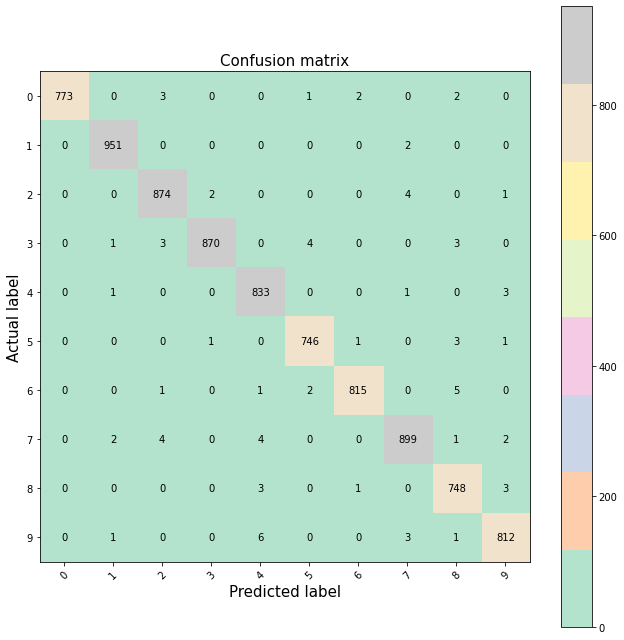

In [30]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel2')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
plt.savefig('CNN-AutoEncoder.png')

### VGG-16 Transfer-Learning

In [31]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [32]:
VGG = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
VGG.trainable = False

model3 = Sequential([
    VGG,
    Flatten(),
    Dense(units=512, activation="relu"),
    Dropout(0.1),
    Dense(units=256, activation="relu"),
    Dropout(0.1),
    Dense(units=10, activation="softmax")
    
])

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [33]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='CNN-VGG16.h5', verbose=1, monitor='val_acc')
cb = [es, mc]

In [34]:
history3 = model3.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(X_test, y_test),
                    callbacks=cb)

Epoch 1/50
263/263 [==============================] - 77s 256ms/step - loss: 0.8003 - accuracy: 0.7390 - val_loss: 0.1978 - val_accuracy: 0.9336

Epoch 00001: saving model to CNN-VGG16.h5
Epoch 2/50
263/263 [==============================] - 42s 158ms/step - loss: 0.1974 - accuracy: 0.9366 - val_loss: 0.1244 - val_accuracy: 0.9623

Epoch 00002: saving model to CNN-VGG16.h5
Epoch 3/50
263/263 [==============================] - 13s 51ms/step - loss: 0.1395 - accuracy: 0.9547 - val_loss: 0.1104 - val_accuracy: 0.9663

Epoch 00003: saving model to CNN-VGG16.h5
Epoch 4/50
263/263 [==============================] - 13s 50ms/step - loss: 0.1220 - accuracy: 0.9602 - val_loss: 0.1162 - val_accuracy: 0.9611

Epoch 00004: saving model to CNN-VGG16.h5
Epoch 5/50
263/263 [==============================] - 13s 50ms/step - loss: 0.1060 - accuracy: 0.9630 - val_loss: 0.1095 - val_accuracy: 0.9657

Epoch 00005: saving model to CNN-VGG16.h5
Epoch 6/50
263/263 [==============================] - 13s 50ms/

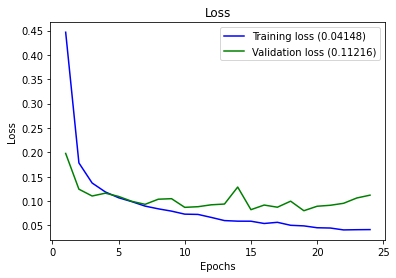

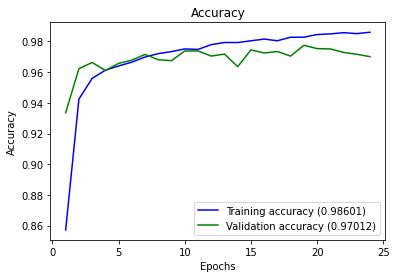

In [35]:
plot_history(history3)

In [36]:
score3 = model3.evaluate(X_test, y_test, verbose=0)
print('Test accuracy CNN VGG-16%:', (score3[1]*100))

Test accuracy CNN VGG-16%: 97.0119059085846


In [37]:
pred_3=model3.predict(X_test, batch_size=128)
y_pred_3= pred_3.argmax(axis=-1)

y_true_onehot = y_test
y_true_label = np.argmax(y_true_onehot, axis=1)
y_true = y_true_label
y_pred3 = y_pred_3
print(y_pred3[0:10])

[1 2 7 1 0 4 6 3 0 3]


In [38]:
cm = confusion_matrix(y_true, y_pred3)
print(cm)

[[767   0   1   0   2   0   7   0   0   4]
 [  0 942   0   0   1   0   0   9   1   0]
 [  1   1 831   5   6   3   5   9  14   6]
 [  0   0   7 843   0   1   4   5  18   3]
 [  0   1   1   0 818   1   3   8   1   5]
 [  1   0   4  13   1 696  21   0  11   5]
 [  2   1   0   0   1   1 816   0   3   0]
 [  0   0   1   1  10   0   1 898   1   0]
 [  0   0   1   1   2   1   5   1 741   3]
 [  2   1   0   0  12   0   3   4   4 797]]


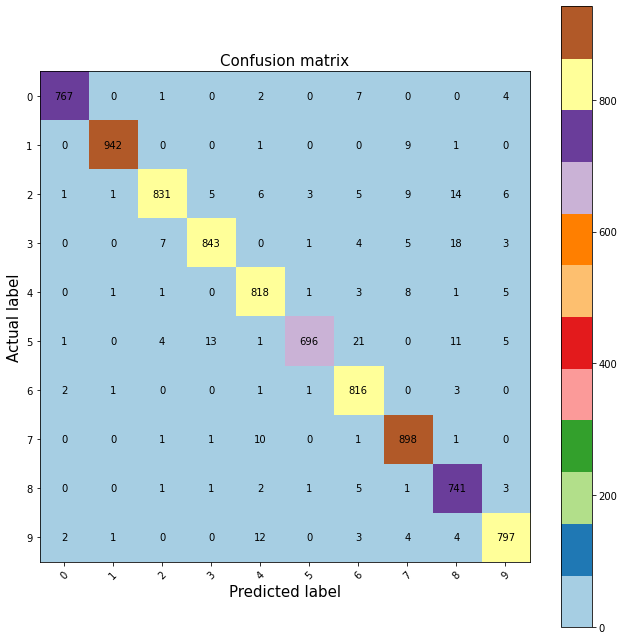

In [39]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Paired')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
plt.savefig('CNN-VGG-16.png')

### VGG-19 Transfer Learning

In [40]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [42]:
VGG = VGG19(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
VGG.trainable = False

model4 = Sequential([
    VGG,
    Flatten(),
    Dense(units=512, activation="relu"),
    Dropout(0.1),
    Dense(units=256, activation="relu"),
    Dropout(0.1),
    Dense(units=10, activation="softmax")
    
])

model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [43]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
mc = ModelCheckpoint(filepath='CNN-VGG19.h5', verbose=1, monitor='val_acc')
cb = [es, mc]

In [44]:
history4 = model4.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_data=(X_test, y_test),
                    callbacks=cb)
scores = model4.evaluate(X_test, y_test, verbose=0)
print('Test accuracy CNN-VGG19-Model%:', (scores[1]*100))

Epoch 1/50
263/263 [==============================] - 17s 62ms/step - loss: 0.7499 - accuracy: 0.7669 - val_loss: 0.1746 - val_accuracy: 0.9464

Epoch 00001: saving model to CNN-VGG19.h5
Epoch 2/50
263/263 [==============================] - 16s 60ms/step - loss: 0.1578 - accuracy: 0.9498 - val_loss: 0.1244 - val_accuracy: 0.9602

Epoch 00002: saving model to CNN-VGG19.h5
Epoch 3/50
263/263 [==============================] - 16s 61ms/step - loss: 0.1348 - accuracy: 0.9562 - val_loss: 0.1195 - val_accuracy: 0.9627

Epoch 00003: saving model to CNN-VGG19.h5
Epoch 4/50
263/263 [==============================] - 16s 61ms/step - loss: 0.1133 - accuracy: 0.9631 - val_loss: 0.1247 - val_accuracy: 0.9614

Epoch 00004: saving model to CNN-VGG19.h5
Epoch 5/50
263/263 [==============================] - 16s 61ms/step - loss: 0.1064 - accuracy: 0.9654 - val_loss: 0.1195 - val_accuracy: 0.9621

Epoch 00005: saving model to CNN-VGG19.h5
Epoch 6/50
263/263 [==============================] - 16s 61ms/st

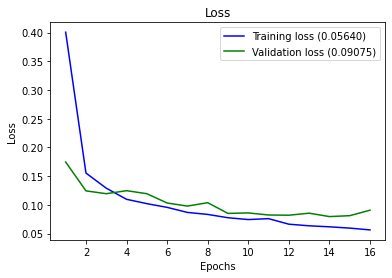

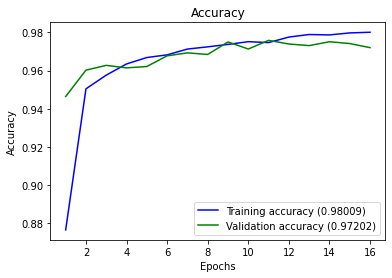

In [45]:
plot_history(history4)

In [46]:
score4 = model4.evaluate(X_test, y_test, verbose=0)
print('Test accuracy CNN VGG-19%:', (score4[1]*100))

Test accuracy CNN VGG-19%: 97.20237851142883


In [47]:
pred_4=model4.predict(X_test, batch_size=128)
y_pred_4= pred_4.argmax(axis=-1)

y_true_onehot = y_test
y_true_label = np.argmax(y_true_onehot, axis=1)
y_true = y_true_label
y_pred4 = y_pred_4
print(y_pred4[0:10])

[1 8 4 1 0 4 6 3 0 3]


In [48]:
cm = confusion_matrix(y_true, y_pred4)
print(cm)

[[771   1   3   0   0   0   4   0   1   1]
 [  0 938   0   0   7   0   1   5   0   2]
 [  0   0 853   2   4   3   1   3  10   5]
 [  0   0  17 840   0  13   2   1   6   2]
 [  0   1   1   0 825   0   2   1   0   8]
 [  1   0  13   4   1 724   1   1   4   3]
 [  0   0   5   0   1   2 814   0   2   0]
 [  0   0   1   0  33   0   0 876   0   2]
 [  1   0  11   0   7   1   2   0 728   5]
 [  0   1   2   0  18   0   0   2   4 796]]


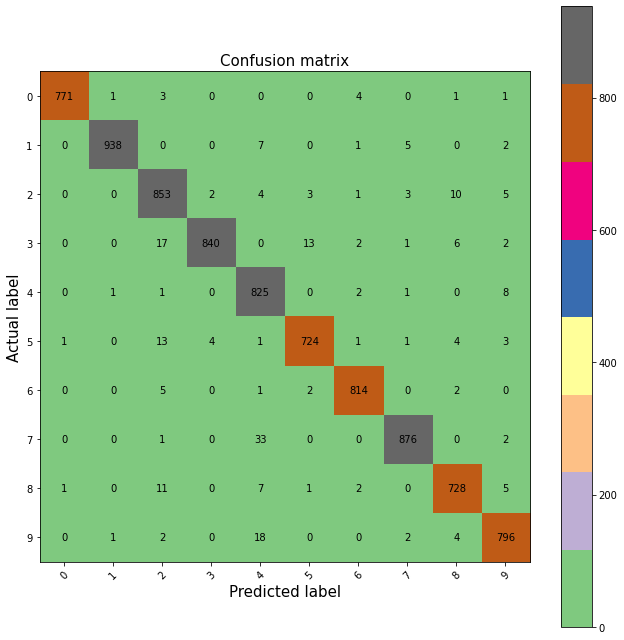

In [49]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Accent')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], rotation=45, size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')
plt.savefig('CNN-VGG-19.png')

### Evaluating and SUBMISSION

As it is observed that CNN Autoencoder is giving the Highest Test Accuracy of 99.01%

We will be submtting that model

In [50]:
from tensorflow.keras.models import load_model

model = load_model('CNN-AutoEncoder.h5')
prediction = model.predict([X_test_final])

In [51]:
print(np.argmax(prediction[0]))

2


<function matplotlib.pyplot.show(close=None, block=None)>

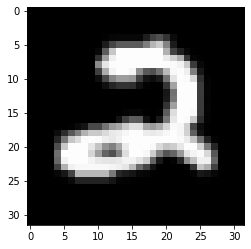

In [52]:
plt.imshow(X_test_final[0])
plt.show

In [53]:
label = [np.argmax(x) for x in prediction]
ImageId = [x+1 for x in range(len(prediction))]

submission = pd.DataFrame({'ImageId': ImageId,
                          'Label' : label}, index = None)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [54]:
submission.to_csv('MySubmission.csv', index=False)